# Cardiovascular Risk Prediction Project
The dataset is from an ongoing cardiovascular study on residents of the town of Framingham, Massachusetts. The classification goal is to predict whether the patient has a 10-year risk of future coronary heart disease (CHD). The dataset provides the patients’ information. It includes over 4,000 records and 15 attributes.

# Importing Libraries

In [1]:
import sagemaker
import boto3
from sagemaker.amazon.amazon_estimator import get_image_uri 
from sagemaker.session import s3_input, Session

In [2]:
bucket_name = 'rohan202' # <--- CHANGE THIS VARIABLE TO A UNIQUE NAME FOR YOUR BUCKET
my_region = boto3.session.Session().region_name # set the region of the instance
print(my_region)

us-east-2


In [3]:
s3 = boto3.resource('s3')
try:
    if  my_region == 'us-east-1':
        s3.create_bucket(Bucket=bucket_name)
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)

S3 bucket created successfully


In [4]:
# set an output path where the trained model will be saved
prefix = 'xgboost-as-a-built-in-algo'
output_path ='s3://{}/{}/output'.format(bucket_name, prefix)
print(output_path)

s3://rohan202/xgboost-as-a-built-in-algo/output


In [5]:
import pandas as pd
import urllib
df= pd.read_csv('data_cardiovascular_risk.csv')

try:
    model_data = pd.read_csv('./data_cardiovascular_risk.csv',index_col=0)
    print('Success: Data loaded into dataframe.')
except Exception as e:
    print('Data load error: ',e)

Success: Data loaded into dataframe.


In [6]:
### Train Test split
import numpy as np
train_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data))])
print(train_data.shape, test_data.shape)

(2373, 16) (1017, 16)


,age,education,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,2373.000000,2314.000000,2354.000000,2340.000000,2373.000000,2373.000000,2373.000000,2345.000000,2373.000000,2373.000000,2362.000000,2372.000000,2156.000000,2373.000000
mean,49.691108,1.975367,8.830926,0.030769,0.007164,0.309735,0.029920,236.271642,132.488622,82.848083,25.793124,75.986509,81.889610,0.149600
std,8.642677,1.029524,11.760514,0.172729,0.084354,0.462482,0.170402,44.107194,22.817607,12.302435,4.178886,12.096783,25.157672,0.356754
min,33.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,113.000000,83.500000,48.000000,15.960000,45.000000,40.000000,0.000000
25%,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,116.000000,74.000000,22.982500,68.000000,71.000000,0.000000
50%,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,233.000000,128.000000,82.000000,25.350000,75.000000,78.000000,0.000000
75%,57.000000,3.000000,20.000000,0.000000,0.000000,1.000000,0.000000,263.000000,144.000000,90.000000,28.030000,83.000000,86.000000,0.000000
max,70.000000,4.000000,70.000000,1.000000,1.000000,1.000000,1.000000,600.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


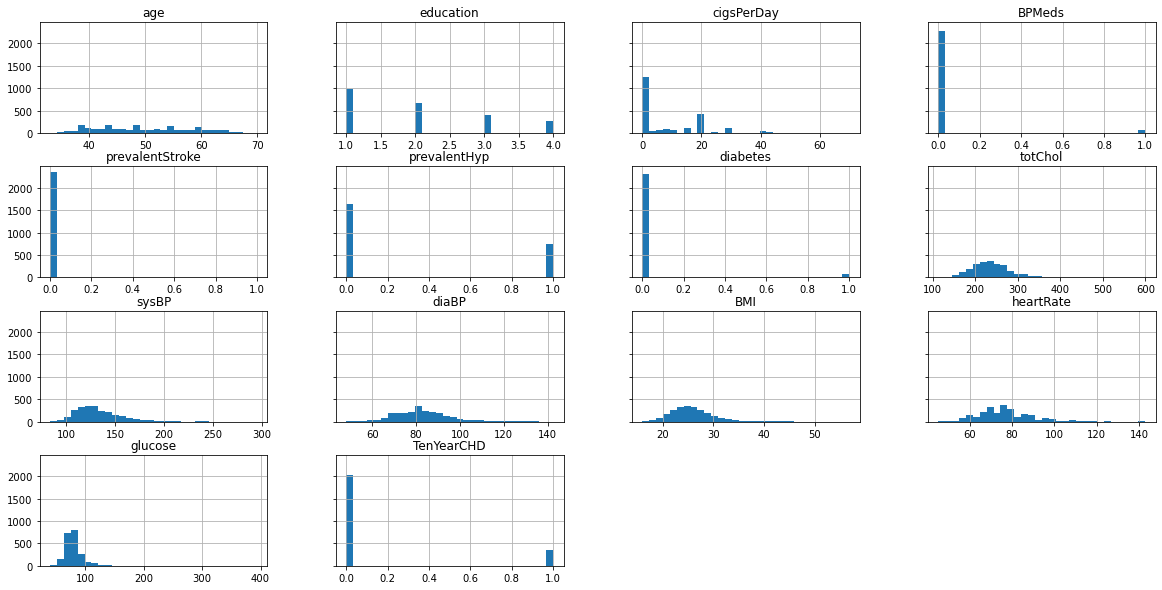

In [7]:
display(train_data.describe())
hist = train_data.hist(bins=30, sharey=True, figsize=(20, 10))

In [8]:
### Saving Train And Test Into Buckets
## We start with Train Data
import os
pd.concat([train_data['TenYearCHD'], train_data.drop(['TenYearCHD'], 
                                                axis=1)], 
                                                axis=1).to_csv('train.csv', index=False, header=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
s3_input_train = sagemaker.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')

In [9]:
# Test Data Into Buckets
pd.concat([test_data['TenYearCHD'], test_data.drop(['TenYearCHD'], axis=1)], axis=1).to_csv('test.csv', index=False, header=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')
s3_input_test = sagemaker.TrainingInput(s3_data='s3://{}/{}/test'.format(bucket_name, prefix), content_type='csv')

In [10]:
from sagemaker.debugger import Rule, rule_configs
from sagemaker.amazon.amazon_estimator import image_uris
container = image_uris.retrieve(region=boto3.Session().region_name, framework='xgboost', version='1.0-1')
print(container)

257758044811.dkr.ecr.us-east-2.amazonaws.com/sagemaker-xgboost:1.0-1-cpu-py3


In [11]:
# initialize hyperparameters
hyperparameters = {
        "max_depth":"5",
        "eta":"0.2",
        "gamma":"4",
        "min_child_weight":"6",
        "subsample":"0.7",
        "objective":"binary:logistic",
        "num_round":50
        }

In [12]:
xgb_model=sagemaker.estimator.Estimator(image_uri=container, 
                                          hyperparameters=hyperparameters,
                                          role=sagemaker.get_execution_role(),
                                          train_instance_count=1, 
                                          train_instance_type='ml.m5.2xlarge', 
                                          train_volume_size=5, # 5 GB 
                                          output_path=output_path,
                                          train_use_spot_instances=True,
                                          train_max_run=300,
                                          train_max_wait=600,
                                          rules=[Rule.sagemaker(rule_configs.create_xgboost_report())])
                                        

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_use_spot_instances has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_wait has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_volume_size has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [13]:
xgb_model.fit({"train": s3_input_train, "validation": s3_input_test}, wait=True)

2022-08-27 17:12:29 Starting - Starting the training job...
2022-08-27 17:12:52 Starting - Preparing the instances for trainingCreateXgboostReport: InProgress
ProfilerReport-1661620349: InProgress
.........
2022-08-27 17:14:28 Downloading - Downloading input data...
2022-08-27 17:14:52 Training - Downloading the training image...
2022-08-27 17:15:29 Uploading - Uploading generated training model.INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[17:15:22] 2373x15 matrix with 35378 entries loaded from /opt/ml/input/data/train?